In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '04_29_24_SpineWeb_ExampleImportance'
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 39000 -> 39000 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                  log_set                                              
/storage/vbutoi/scratch/ESE/inference/04_29_24_SpineWeb_ExampleImportance/SpineWeb_Ensemble_Uncalibrated  20240429_103649-YQF9-1cc926cd77479898bae7fc7dac28514a    10500
                                                                                                          20240429_103653-17ND-03ae253a03627f26ce0c1e5e90677394    10500
                                                                                                          20240429_103657-FZPO-d6a66057af8095f529b4c190e06067ba    10500
                                                                                                          20240429_103702-FBBD-428614f61a0b8369606d28b3d44dd6c1    10500
dtype: int64


In [4]:
image_info_df['support_data_ids']

0        (Subject02, Subject08, Subject11, Subject08, S...
1        (Subject02, Subject08, Subject11, Subject08, S...
2        (Subject02, Subject08, Subject11, Subject08, S...
3        (Subject02, Subject08, Subject11, Subject08, S...
4        (Subject02, Subject08, Subject11, Subject08, S...
                               ...                        
41995    (Subject03, Subject15, Subject08, Subject03, S...
41996    (Subject03, Subject15, Subject08, Subject03, S...
41997    (Subject07, Subject08, Subject08, Subject08, S...
41998    (Subject07, Subject08, Subject08, Subject08, S...
41999    (Subject07, Subject08, Subject08, Subject08, S...
Name: support_data_ids, Length: 42000, dtype: object

## Experiment 1: Is there a critical example determining performance?

In [5]:
import ast 

# First we need to get all of the unique support data ids by going through the unique values of the column and assembling a list.
unique_supports = image_info_df['support_data_ids'].unique()
unique_ids = []
for support in unique_supports:
    support_list = list(support)
    unique_ids = list(set(unique_ids).union(support_list))
# Sort the list just for aesthetics.
unique_ids.sort()

In [6]:
# Iterate through each of the subjects, making a duplicate of the original dataframe, and marking
# each row prediction with a 'includes' or 'excludes' based on the support data ids and the subject id.
subject_dfs = {}
for subject_id in unique_ids:
    subject_df = image_info_df.copy()
    subject_df['subject_id'] = subject_id
    subject_df['includes'] = subject_df['support_data_ids'].apply(lambda x: subject_id in x)
    subject_dfs[subject_id] = subject_df
# Combine all of the dataframes into a single one.
combined_df = pd.concat(subject_dfs.values(), ignore_index=True)

In [7]:
combined_df['includes'] = combined_df['includes'].astype('category')
combined_df['includes'] = combined_df['includes'].cat.reorder_categories([
    True,
    False
])

In [8]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe
df_pivot = combined_df.pivot(index=['experiment.seed', 'data_id', 'sup_idx', 'subject_id', 'includes'], columns='image_metric', values='metric_score').reset_index()

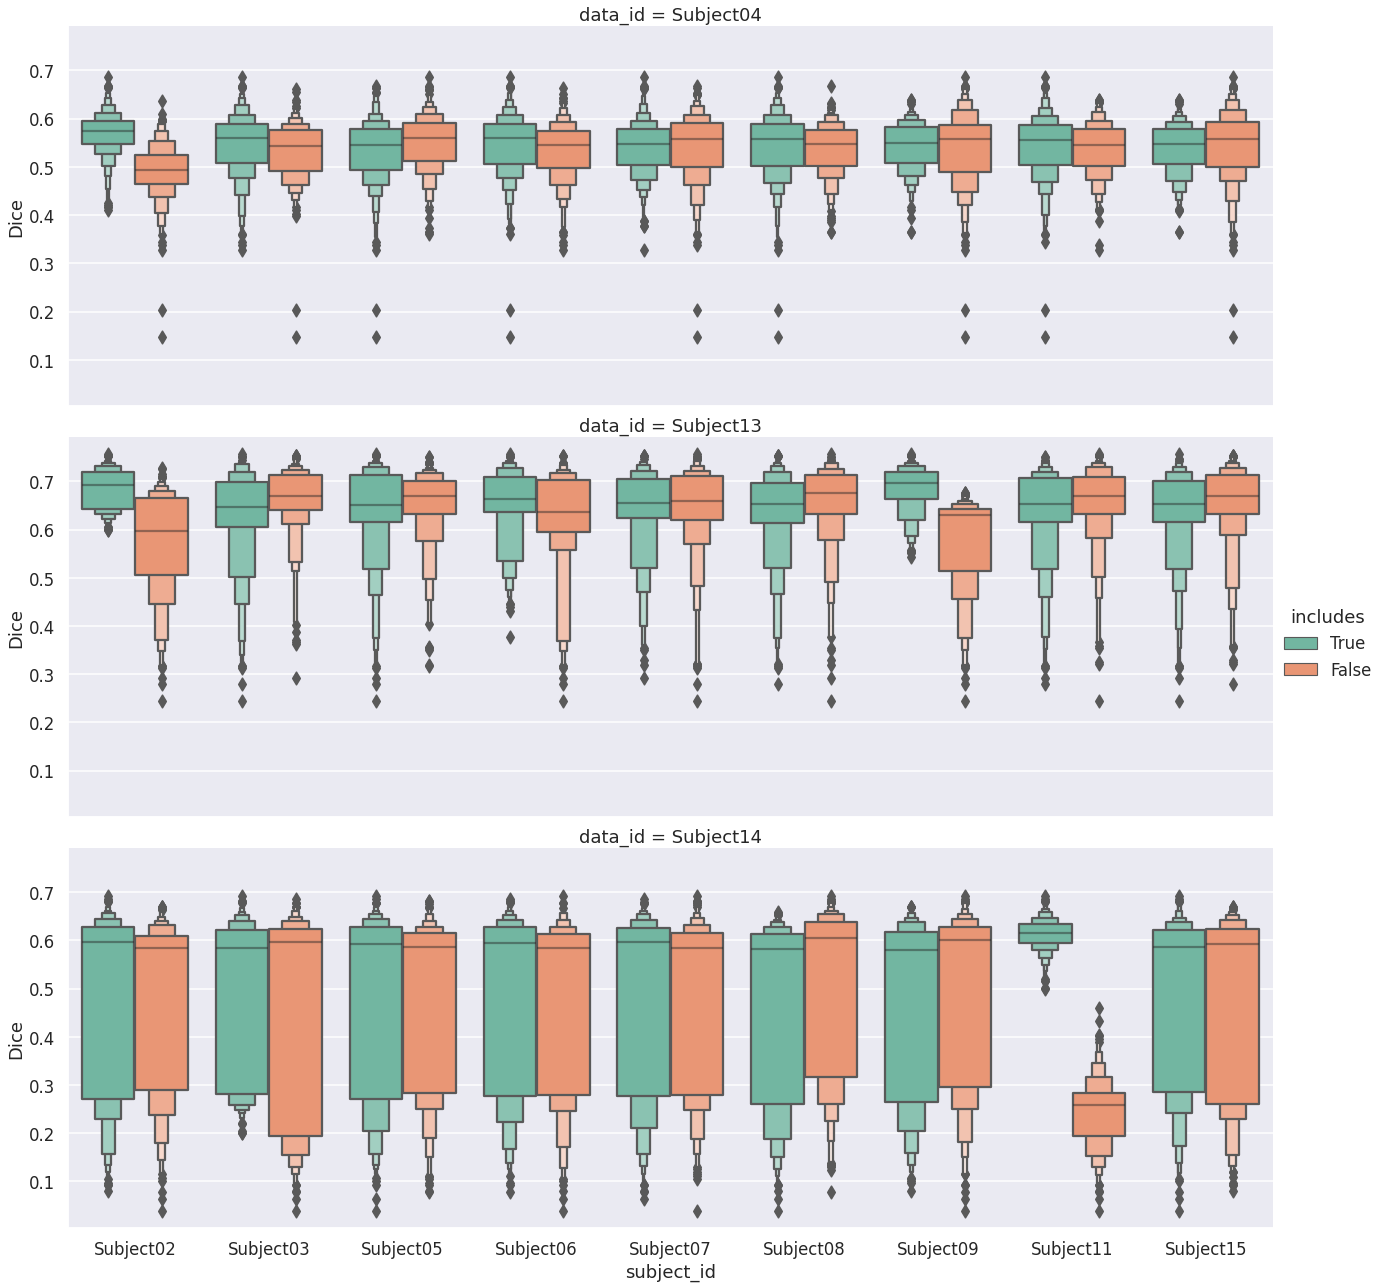

In [9]:
sns.catplot(
    data=df_pivot,
    x='subject_id',
    y='Dice',
    row='data_id',
    hue='includes',
    kind='boxen',
    aspect=3,
    height=6,
    palette='Set2',
)

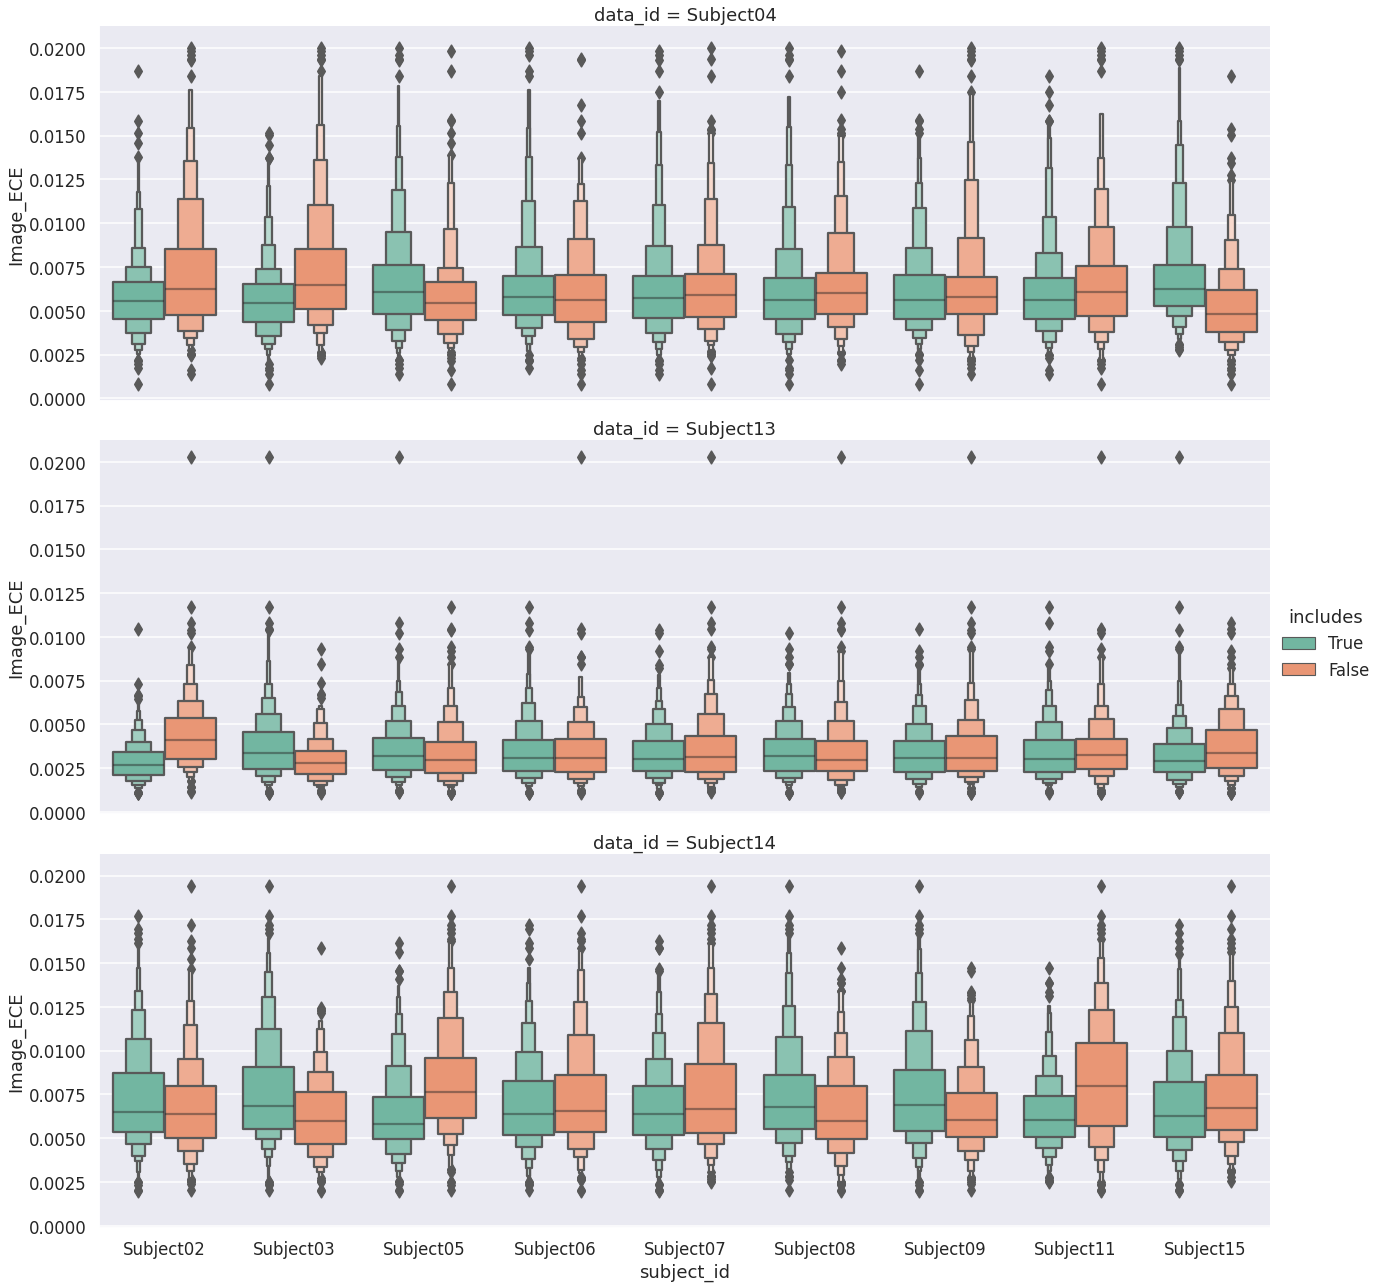

In [10]:
sns.catplot(
    data=df_pivot,
    x='subject_id',
    y='Image_ECE',
    row='data_id',
    hue='includes',
    kind='boxen',
    aspect=3,
    height=6,
    palette='Set2',
)

## Experiment 2: Does the number of times this critical example appear matter?

In [11]:
outlier_df = image_info_df[image_info_df['data_id'] == 'Subject14'].copy()

In [12]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe

# Ran over multiple seeds to parralleize the 1000 into faster
outlier_df = outlier_df.pivot(index=['experiment.seed', 'sup_idx', 'support_data_ids'], columns='image_metric', values='metric_score').reset_index()

In [13]:
def num_appearances(support_data_ids):
    return int(support_data_ids.count('Subject11'))

In [14]:
outlier_df.augment(num_appearances)

In [15]:
outlier_df['num_appearances'].unique()

array([3, 1, 2, 0, 4])

In [16]:
outlier_df['num_appearances']

0      3
1      3
2      1
3      2
4      2
      ..
995    3
996    1
997    0
998    0
999    1
Name: num_appearances, Length: 1000, dtype: int64

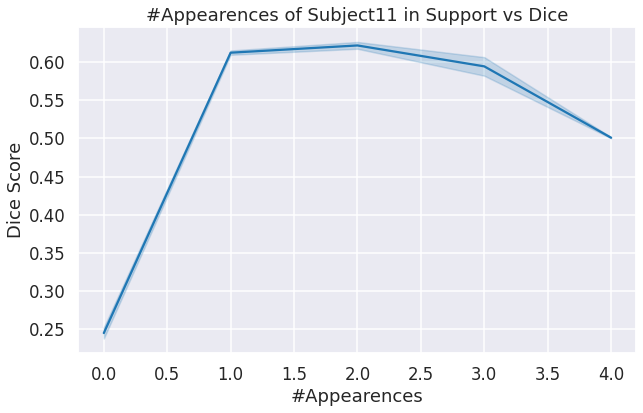

In [17]:
# Assuming outlier_df is your DataFrame
# Vjj
# sns.set(style="whitegrid")  # Set the style of the plot

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x="num_appearances", y="Dice", data=outlier_df)

# Adding title and labels
plt.title('#Appearences of Subject11 in Support vs Dice')
plt.xlabel('#Appearences')
plt.ylabel('Dice Score')

# Show the plot
plt.show()